In [1]:
"""
Purpose: To run the soma splitting 
on the processed neurons

"""


'\nPurpose: To run the soma splitting \non the processed neurons\n\n'

In [2]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
sys.path.append("/meshAfterParty/")

import datajoint_utils as du
from importlib import reload

INFO - 2021-01-19 03:14:00,699 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-01-19 03:14:00,701 - settings - Setting database.user to celiib
INFO - 2021-01-19 03:14:00,702 - settings - Setting database.password to newceliipass
INFO - 2021-01-19 03:14:00,724 - settings - Setting stores to {'minnie65': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65', 'stage': '/mnt/dj-stor01/platinum/minnie65'}, 'meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/meshes'}, 'decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes', 'stage': '/mnt/dj-stor01/platinum/minnie65/02/decimated_meshes'}, 'skeletons': {'protocol': 'file', 'location': '/mnt/dj-stor01/platinum/minnie65/02/skeletons'}}
INFO - 2021-01-19 03:14:00,725 - settings - Setting enable_python_native_blobs to True
INFO - 2021-01-19 03:14:00,737 - connection - Connect

Connecting celiib@at-database.ad.bcm.edu:3306


INFO - 2021-01-19 03:14:01,007 - settings - Setting enable_python_native_blobs to True


In [3]:
test_mode = True

In [4]:
import minfig
import time
import numpy as np
#want to add in a wait for the connection part
random_sleep_sec = np.random.randint(0, 200)
print(f"Sleeping {random_sleep_sec} sec before conneting")
if not test_mode:
    time.sleep(random_sleep_sec)
print("Done sleeping")

du.config_celii()
du.set_minnie65_config_segmentation(minfig)
du.print_minnie65_config_paths(minfig)

#configuring will include the adapters
minnie,schema = du.configure_minnie_vm()

INFO - 2021-01-19 03:14:01,049 - settings - Setting database.host to at-database.ad.bcm.edu
INFO - 2021-01-19 03:14:01,049 - settings - Setting database.user to celiib
INFO - 2021-01-19 03:14:01,050 - settings - Setting database.password to newceliipass
INFO - 2021-01-19 03:14:01,053 - settings - Setting enable_python_native_blobs to True


Sleeping 167 sec before conneting
Done sleeping
Current path for external_segmentation_path = /mnt/dj-stor01/platinum/minnie65/02
Current path for external_mesh_path = /mnt/dj-stor01/platinum/minnie65/02/meshes
Current path for external_decimated_mesh_path = /mnt/dj-stor01/platinum/minnie65/02/decimated_meshes
Current path for external_skeleton_path = /mnt/dj-stor01/platinum/minnie65/02/skeletons


INFO - 2021-01-19 03:14:01,322 - settings - Setting enable_python_native_blobs to True


# Defining the Table

In [5]:
import neuron_utils as nru
import neuron
import trimesh_utils as tu
import numpy as np

In [6]:
import meshlab
meshlab.set_meshlab_port(current_port=None)

No port chosen so picked random port 4957


In [7]:
#so that it will have the adapter defined
from datajoint_utils import *

In [9]:
import numpy as np
import time
import proofreading_utils as pru

@schema
class NeuronSplitSuggestions(dj.Computed):
    definition="""
    -> minnie.Decomposition
    ---
    split_results: longblob #will store the results of how to split the limbs of neuron objects
    run_time=NULL : double                   # the amount of time to run (seconds)

    """

    key_source = minnie.Decomposition() & minnie.MultiSomaProofread2.proj()
    
    def make(self,key):
        """
        Pseudocode for process:

        1) Fetch the neuron object
        2) Run the mutli-split suggestions
        3) Calculate the total time
        4) Write the results to the table
        """
        whole_pass_time = time.time()
        #1) Get the segment id from the key
        segment_id = key["segment_id"]
        print(f"\n\n----- Working on Neuron {segment_id}-------")
        
        neuron_obj = (minnie.Decomposition & key).fetch1("decomposition")
        
        limb_results = pru.multi_soma_split_suggestions(neuron_obj,plot_intermediates=False)
        
        #7) Pass stats and file location to insert
        new_key = dict(key,
                       split_results = limb_results,
                       run_time=np.round(time.time() - whole_pass_time,4)
                      )

        self.insert1(new_key, allow_direct_insert=True, skip_duplicates=True)

        print(f"\n\n ------ Total time for Splitting {segment_id} = {time.time() - whole_pass_time} ------")
    

# Running the Populate

In [10]:
curr_table = (minnie.schema.jobs & "table_name='__neuron_split_suggestions'")
(curr_table)#.delete()# & "status='error'")
#curr_table.delete()
#(curr_table & "error_message = 'ValueError: need at least one array to concatenate'").delete()

table_name className of the table,key_hash key hash,"status if tuple is missing, the job is available",key structure containing the key,error_message error message returned if failed,error_stack error stack if failed,user database user,host system hostname,pid system process id,connection_id connection_id(),timestamp automatic timestamp
__neuron_split_suggestions,13123179026cc7faebd655f15ef45844,reserved,=BLOB=,,=BLOB=,celiib@10.21.18.111,71caefafdeec,712,53510,2021-01-18 21:15:58
__neuron_split_suggestions,2780b8fac28058d79ec92cb360ccb2d6,reserved,=BLOB=,,=BLOB=,celiib@10.21.18.111,71caefafdeec,32522,53503,2021-01-18 21:14:54
__neuron_split_suggestions,5453421d86ee5dd7d7209e49dedc205e,reserved,=BLOB=,,=BLOB=,celiib@10.21.18.111,71caefafdeec,317,53507,2021-01-18 21:15:26
__neuron_split_suggestions,994bf9403e5bc2fb25a3666b4a6446f5,reserved,=BLOB=,,=BLOB=,celiib@10.21.18.111,71caefafdeec,32396,53500,2021-01-18 21:15:51
__neuron_split_suggestions,bb27471bdf6ca6d0feeaee1c45e4498b,reserved,=BLOB=,,=BLOB=,celiib@10.21.18.111,71caefafdeec,32631,53505,2021-01-18 21:15:12
__neuron_split_suggestions,dcd361f29ba0cff26aac4265a115c6c3,reserved,=BLOB=,,=BLOB=,celiib@10.21.18.111,71caefafdeec,32459,53501,2021-01-18 21:14:32


INFO - 2021-01-19 03:16:53,279 - autopopulate - Found 48 keys to populate
INFO - 2021-01-19 03:16:53,307 - connection - Transaction started
INFO - 2021-01-19 03:16:53,309 - autopopulate - Populating: {'segment_id': 864691135210051520, 'decimation_version': 0, 'decimation_ratio': Decimal('0.25'), 'ver': Decimal('29.00'), 'process_version': 0, 'index': 0}


Populate Started


----- Working on Neuron 864691135210051520-------
Decompressing Neuron in minimal output mode...please wait
multi_soma_limbs = []
multi_touch_limbs = [0]


 -------- Working on limb 0------------
Starting combinations to process = [[17 25]
 [17 27]
 [25 27]]


---- working on disconnecting 17 and 25
---- This disconnects S0_2 from S0_0  
 Cut iteration 0
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 1
Total number of graphs at the end of the split AFTER DIRECTIONAL = 1
Shortest path = [17, 18, 22, 27, 30, 33, 31, 26, 24, 25]

 --------- START OF GET BEST EDGE --------- 
curr_limb.deleted_edges=[]
consider_path_neighbors_for_removal is set so segments_to_consider = [ 3 10 12 15 18 21 22 24 26 27 28 29 30 31 32 33 34]
Short segments to combine = []
Found 2 high degree coordinates to cut
Picking [890722. 694193. 841705.] high degree coordinates to cut
curr_limb.deleted_edges 4=[]
***inside resolve crossover!!!!****
coordinate_branches = [10, 15, 17

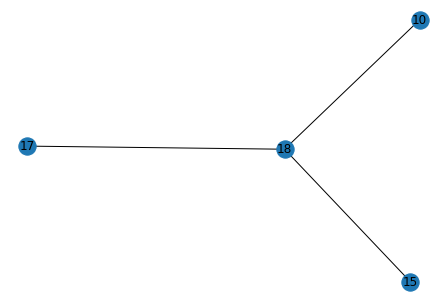

match_branches = []
edges_to_delete (resolve crossover) = [[10, 15], [10, 17], [10, 18], [15, 17], [15, 18], [17, 18]]
edges_to_create (resolve crossover) = []
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[10, 15], [10, 17], [10, 18], [15, 17], [15, 18], [17, 18]]
edges_to_create = []
Number of connected components = 4
Comp 0 = {1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 14, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64}
Comp 1 = {10}
Comp 2 = {0, 6, 15}
Comp 3 = {17}
curr_limb_copy.deleted_edges = [[10, 15], [10, 17], [10, 18], [15, 17], [15, 18], [17, 18]]
curr_limb_copy.created_edges = []
After get best cut: cut_edges = [[10, 15], [10, 17], [10, 18], [15, 17], [15, 18], [17, 18]], added_edges = []
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the en

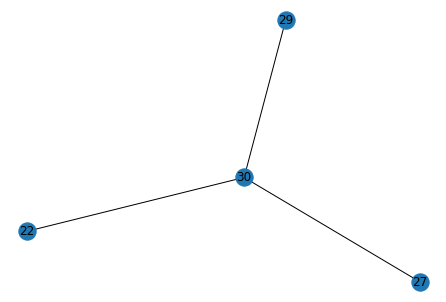

match_branches = [[27, 30]]
edges_to_delete (resolve crossover) = [[22, 27], [22, 29], [22, 30], [27, 29], [29, 30]]
edges_to_create (resolve crossover) = [[27, 30]]
curr_limb.deleted_edges 5 =[[10, 15], [10, 17], [10, 18], [15, 17], [15, 18], [17, 18]]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[22, 27], [22, 29], [22, 30], [27, 29], [29, 30]]
edges_to_create = [[27, 30]]
Number of connected components = 6
Comp 0 = {1, 2, 3, 4, 5, 7, 8, 9, 11, 13, 14, 16, 19, 21, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64}
Comp 1 = {18, 12, 22}
Comp 2 = {20, 29, 23}
Comp 3 = {10}
Comp 4 = {0, 6, 15}
Comp 5 = {17}
curr_limb_copy.deleted_edges = [[10, 15], [10, 17], [10, 18], [15, 17], [15, 18], [17, 18], [22, 27], [22, 29], [22, 30], [27, 29], [29, 30]]
curr_limb_copy.created_edges = [[27, 30]]
After get best cut: cut_edges = [[22, 27], [22, 29], [22, 30], [27, 29], [29, 30]], 

  Edge: [25 24]: curr_angle = 43.09
  Edge: [24 26]: curr_angle = 65.47
  Edge: [26 31]: curr_angle = 29.92
  Edge: [31 33]: curr_angle = 160.59
  Edge: [33 30]: curr_angle = 40.76
  Edge: [30 27]: curr_angle = 25.63

Total time for doubling_back = 0.2815537452697754
There were 1 edges that passed doubling back threshold of 100
Winning edge [31 33] had a doubling back of 160.59449297630042
***inside resolve crossover!!!!****
coordinate_branches = [3, 31, 33]
3 = red
31 = aqua
33 = purple
Angle between 3 and 31 = 22.14 
Angle between 3 and 33 = 26.82 
Angle between 31 and 33 = 135.38 
Final Matches = [[3, 31], [3, 33]]
matched_branches_revised = [[3, 31]]
Original graph


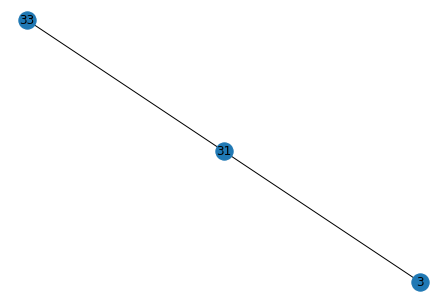

match_branches = [[3, 31]]
edges_to_delete (resolve crossover) = [[3, 33], [31, 33]]
edges_to_create (resolve crossover) = [[3, 31]]
edges_to_delete (cut_limb_network) = [array([ 3, 33]), array([31, 33])]
edges_to_create = [[3, 31]]
Number of connected components = 7
Comp 0 = {1, 2, 3, 4, 5, 7, 8, 9, 11, 13, 14, 16, 19, 21, 24, 25, 26, 28, 31, 32, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64}
Comp 1 = {33, 34, 27, 30}
Comp 2 = {18, 12, 22}
Comp 3 = {20, 29, 23}
Comp 4 = {10}
Comp 5 = {0, 6, 15}
Comp 6 = {17}
curr_limb_copy.deleted_edges = [[10, 15], [10, 17], [10, 18], [15, 17], [15, 18], [17, 18], [22, 27], [22, 29], [22, 30], [27, 29], [29, 30], array([ 3, 33]), array([31, 33])]
curr_limb_copy.created_edges = [[27, 30], [3, 31]]
After get best cut: cut_edges = [array([ 3, 33]), array([31, 33])], added_edges = [[3, 31]]
total_soma_paths_to_cut = [[22, 27], [22, 29], [22, 30], [27, 29], [29, 30]]
-----------count

  Edge: [6 7]: curr_angle = 9.68
  Edge: [ 7 13]: curr_angle = 109.2
  Edge: [13 14]: curr_angle = 39.16
  Edge: [14 22]: curr_angle = 30.51
  Edge: [22 17]: curr_angle = 58.39
  Edge: [17 15]: curr_angle = 39.03

Total time for doubling_back = 0.9467079639434814
There were 1 edges that passed doubling back threshold of 100
Winning edge [ 7 13] had a doubling back of 109.19820890310956
***inside resolve crossover!!!!****
coordinate_branches = [7, 12, 13]
7 = red
12 = aqua
13 = purple
Angle between 7 and 12 = 94.98 
Angle between 7 and 13 = 121.57 
Angle between 12 and 13 = 51.62 
Final Matches = []
matched_branches_revised = []
Original graph


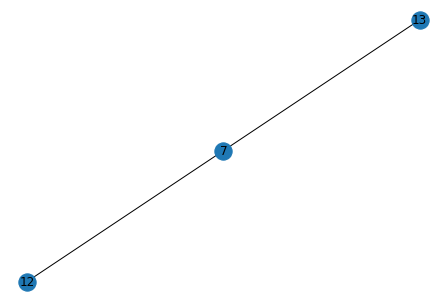

match_branches = []
edges_to_delete (resolve crossover) = [[7, 12], [7, 13], [12, 13]]
edges_to_create (resolve crossover) = []
edges_to_delete (cut_limb_network) = [array([ 7, 12]), array([ 7, 13]), array([12, 13])]
edges_to_create = []
Number of connected components = 3
Comp 0 = {1, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26}
Comp 1 = {8, 6, 7}
Comp 2 = {0, 2, 3, 4, 5, 9, 10, 11, 12}
curr_limb_copy.deleted_edges = [array([ 7, 12]), array([ 7, 13]), array([12, 13])]
curr_limb_copy.created_edges = []
After get best cut: cut_edges = [array([ 7, 12]), array([ 7, 13]), array([12, 13])], added_edges = []
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 3: [array([ 1, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,

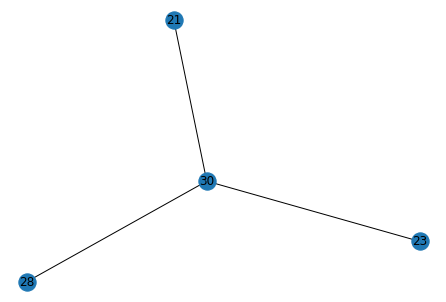

match_branches = [[23, 28]]
edges_to_delete (resolve crossover) = [[21, 23], [21, 28], [21, 30], [23, 30], [28, 30]]
edges_to_create (resolve crossover) = [[23, 28]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 34 because skeletal distance was 2134.9883507519303 and threshold was 2500
Skipping endnode 53 because skeletal distance was 1416.0614929697347 and threshold was 2500
skip_nodes = [34, 53]
edges_to_delete (cut_limb_network) = [[21, 23], [21, 28], [21, 30], [23, 30], [28, 30]]
edges_to_create = [[23, 28]]
Number of connected components = 5
Comp 0 = {0, 1, 2, 4, 6, 7, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 24, 26, 29, 33, 34, 37, 38, 41, 48, 49, 56, 58, 59, 60}
Comp 1 = {35, 9, 43, 51, 22, 23, 28}
Comp 2 = {32, 3, 36, 5, 39, 40, 42, 44, 45, 46, 47, 13, 50, 52, 53, 54, 55, 25, 57, 30}
Comp 3 = {27}
Comp 4 = {31}
curr_limb_copy.deleted_edges = [[21, 23], [21, 28], [21, 30], [23, 30], [28, 30]]
curr_limb_copy.created_edges = [[23, 28]]
After get best cut: cut_edges = [[21, 

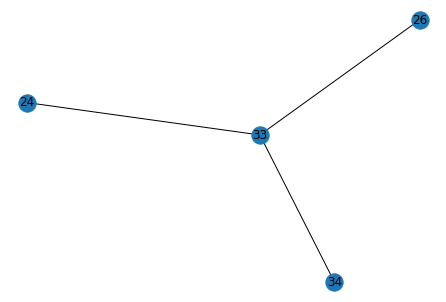

match_branches = [[26, 34]]
edges_to_delete (resolve crossover) = [[24, 26], [24, 33], [24, 34], [26, 33], [33, 34]]
edges_to_create (resolve crossover) = [[26, 34]]
curr_limb.deleted_edges 5 =[[21, 23], [21, 28], [21, 30], [23, 30], [28, 30]]
Skipping endnode 34 because skeletal distance was 2134.9883507519303 and threshold was 2500
skip_nodes = [34]
edges_to_delete (cut_limb_network) = [[24, 26], [24, 33], [24, 34], [26, 33], [33, 34]]
edges_to_create = [[26, 34]]
Number of connected components = 7
Comp 0 = {0, 1, 2, 4, 6, 8, 10, 11, 12, 15, 16, 21, 29, 33, 37, 38, 41, 48, 49, 56, 58, 59, 60}
Comp 1 = {14, 17, 19, 20, 24}
Comp 2 = {26, 18, 34, 7}
Comp 3 = {35, 9, 43, 51, 22, 23, 28}
Comp 4 = {32, 3, 36, 5, 39, 40, 42, 44, 45, 46, 47, 13, 50, 52, 53, 54, 55, 25, 57, 30}
Comp 5 = {27}
Comp 6 = {31}
curr_limb_copy.deleted_edges = [[21, 23], [21, 28], [21, 30], [23, 30], [28, 30], [24, 26], [24, 33], [24, 34], [26, 33], [33, 34]]
curr_limb_copy.created_edges = [[23, 28], [26, 34]]
After 

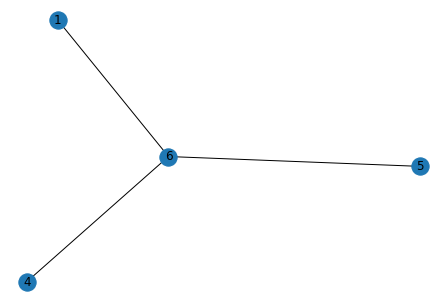

match_branches = [[1, 6], [4, 5]]
edges_to_delete (resolve crossover) = [[1, 4], [1, 5], [4, 6], [5, 6]]
edges_to_create (resolve crossover) = [[1, 6], [4, 5]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[1, 4], [1, 5], [4, 6], [5, 6]]
edges_to_create = [[1, 6], [4, 5]]
Number of connected components = 2
Comp 0 = {0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43}
Comp 1 = {3, 4, 5, 15}
curr_limb_copy.deleted_edges = [[1, 4], [1, 5], [4, 6], [5, 6]]
curr_limb_copy.created_edges = [[1, 6], [4, 5]]
After get best cut: cut_edges = [[1, 4], [1, 5], [4, 6], [5, 6]], added_edges = [[1, 6], [4, 5]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next c

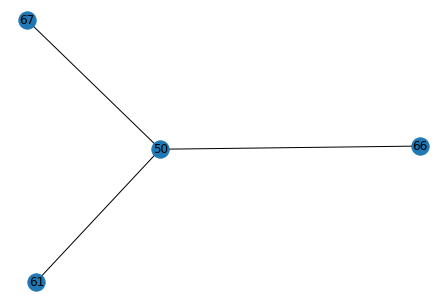

match_branches = [[50, 67], [61, 66]]
edges_to_delete (resolve crossover) = [[50, 61], [50, 66], [61, 67], [66, 67]]
edges_to_create (resolve crossover) = [[50, 67], [61, 66]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[50, 61], [50, 66], [61, 67], [66, 67]]
edges_to_create = [[50, 67], [61, 66]]
Number of connected components = 2
Comp 0 = {32, 39, 40, 41, 42, 45, 46, 49, 50, 54, 55, 56, 57, 58, 63, 64, 65, 67, 68, 69, 70, 71, 72}
Comp 1 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 43, 44, 47, 48, 51, 52, 53, 59, 60, 61, 62, 66, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100}
curr_limb_copy.deleted_edges = [[50, 61], [50, 66], [61, 67], [66, 67]]
curr_limb_copy.created_edges = [[50, 67], [61, 66]]
After get best cut: cut_edges = [[50, 61], [50, 66], [61, 67], [66, 67]], added_edges =

  Edge: [27 29]: curr_angle = 57.94
  Edge: [29 26]: curr_angle = 90.63
  Edge: [26 24]: curr_angle = 3.89
  Edge: [24 18]: curr_angle = 28.19
  Edge: [18 16]: curr_angle = 12.37
  Edge: [16 17]: curr_angle = 18.7
  Edge: [17 15]: curr_angle = 28.75
  Edge: [15 14]: curr_angle = 22.03
  Edge: [14 23]: curr_angle = 3.06
  Edge: [23 20]: curr_angle = 27.73
  Edge: [20 47]: curr_angle = 30.08
  Edge: [47 62]: curr_angle = 45.33
  Edge: [62 75]: curr_angle = 7.84
  Edge: [75 78]: curr_angle = 9.85
  Edge: [78 79]: curr_angle = 10.14
  Edge: [79 82]: curr_angle = 30.64
  Edge: [82 84]: curr_angle = 29.15

Total time for doubling_back = 2.887469530105591

Attempting the width jump check (attempting from both sides)
  Edge: [27 29]: jump = -533.33
  Edge: [29 26]: jump = 388.73
Adding error edge [29 26] because width jump was 388.73106345195043
  Edge: [26 24]: jump = -75.29
  Edge: [24 18]: jump = 67.01
  Edge: [18 16]: jump = -80.91
  Edge: [16 17]: jump = -105.58
  Edge: [17 15]: jump = -3

  Edge: [50 46]: curr_angle = 28.51
  Edge: [46 39]: curr_angle = 51.94
  Edge: [39 38]: curr_angle = 36.69
  Edge: [38 40]: curr_angle = 37.04
  Edge: [40 65]: curr_angle = 21.04
  Edge: [65 60]: curr_angle = 48.93
  Edge: [60 62]: curr_angle = 95.93
  Edge: [62 59]: curr_angle = 105.15
  Edge: [59 19]: curr_angle = 12.43
  Edge: [19 20]: curr_angle = 167.14
  Edge: [20 54]: curr_angle = 52.4
  Edge: [54 63]: curr_angle = 31.99
  Edge: [63 77]: curr_angle = 36.85
  Edge: [77 79]: curr_angle = 33.47
  Edge: [79 84]: curr_angle = 14.57
  Edge: [84 80]: curr_angle = 1.25

Total time for doubling_back = 0.8710837364196777
There were 2 edges that passed doubling back threshold of 100
Winning edge [19 20] had a doubling back of 167.14050266507303
***inside resolve crossover!!!!****
coordinate_branches = [16, 19, 20]
16 = red
19 = aqua
20 = purple
Angle between 16 and 19 = 36.43 
Angle between 16 and 20 = 5.73 
Angle between 19 and 20 = 144.0 
Final Matches = [[16, 20]]
matched_branches_revi

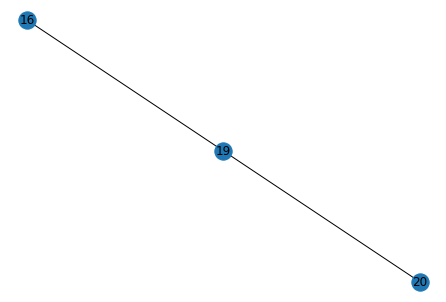

match_branches = [[16, 20]]
edges_to_delete (resolve crossover) = [[16, 19], [19, 20]]
edges_to_create (resolve crossover) = [[16, 20]]
edges_to_delete (cut_limb_network) = [array([16, 19]), array([19, 20])]
edges_to_create = [[16, 20]]
Number of connected components = 2
Comp 0 = {0, 2, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 17, 18, 19, 22, 23, 25, 27, 28, 29, 30, 31, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 87, 88, 89, 90, 91, 92, 93, 94, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114}
Comp 1 = {1, 3, 11, 15, 16, 20, 21, 24, 26, 32, 33, 43, 52, 53, 54, 63, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 95, 96, 97, 98, 99, 100}
curr_limb_copy.deleted_edges = [array([16, 19]), array([19, 20])]
curr_limb_copy.created_edges = [[16, 20]]
After get best cut: cut_edges = [array([16, 19]), array([19, 20])], added_edges = [[16, 20]]
total_soma_paths_to_cut = []
-----------co

  Edge: [50 46]: curr_angle = 28.51
  Edge: [46 39]: curr_angle = 51.94
  Edge: [39 38]: curr_angle = 36.69
  Edge: [38 40]: curr_angle = 37.04
  Edge: [40 65]: curr_angle = 21.04
  Edge: [65 60]: curr_angle = 48.93
  Edge: [60 62]: curr_angle = 95.93
  Edge: [62 68]: curr_angle = 75.63
  Edge: [68 92]: curr_angle = 49.7
  Edge: [92 94]: curr_angle = 8.38
  Edge: [ 94 108]: curr_angle = 17.34
  Edge: [108 109]: curr_angle = 10.17
  Edge: [109 113]: curr_angle = 16.08
  Edge: [113 114]: curr_angle = 4.46

Total time for doubling_back = 1.3570218086242676

Attempting the width jump check (attempting from both sides)
  Edge: [50 46]: jump = -225.64
  Edge: [46 39]: jump = -245.68
  Edge: [39 38]: jump = -195.59
  Edge: [38 40]: jump = -31.51
  Edge: [40 65]: jump = -20.4
  Edge: [65 60]: jump = -368.13
  Edge: [60 62]: jump = -57.94
  Edge: [62 68]: jump = 338.6
Adding error edge [62 68] because width jump was 338.6018730915793
  Edge: [68 92]: jump = 121.48
  Edge: [92 94]: jump = -64.75

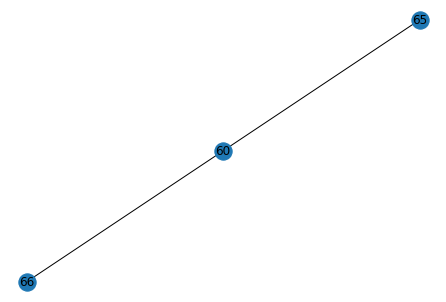

match_branches = [[65, 66]]
edges_to_delete (resolve crossover) = [[60, 65], [60, 66]]
edges_to_create (resolve crossover) = [[65, 66]]
edges_to_delete (cut_limb_network) = [array([60, 65]), array([60, 66])]
edges_to_create = [[65, 66]]
Number of connected components = 3
Comp 0 = {0, 2, 4, 5, 6, 9, 10, 12, 13, 14, 18, 22, 25, 27, 28, 29, 30, 31, 34, 35, 37, 38, 39, 40, 41, 42, 45, 46, 48, 50, 51, 56, 57, 61, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 89, 90}
Comp 1 = {7, 8, 17, 19, 23, 36, 44, 47, 49, 55, 58, 59, 60, 62, 68, 87, 88, 91, 92, 93, 94, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114}
Comp 2 = {1, 3, 11, 15, 16, 20, 21, 24, 26, 32, 33, 43, 52, 53, 54, 63, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 95, 96, 97, 98, 99, 100}
curr_limb_copy.deleted_edges = [array([16, 19]), array([19, 20]), array([60, 65]), array([60, 66])]
curr_limb_copy.created_edges = [[16, 20], [65, 66]]
After get best cut: cut_edges = [array([60, 65]), array([60, 66])], added_edges =

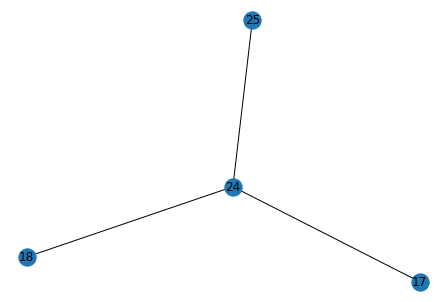

match_branches = [[18, 25], [17, 24]]
edges_to_delete (resolve crossover) = [[17, 18], [17, 25], [18, 24], [24, 25]]
edges_to_create (resolve crossover) = [[18, 25], [17, 24]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 37 because skeletal distance was 1622.9915301622154 and threshold was 2500
skip_nodes = [37]
edges_to_delete (cut_limb_network) = [[17, 18], [17, 25], [18, 24], [24, 25]]
edges_to_create = [[18, 25], [17, 24]]
Number of connected components = 2
Comp 0 = {2, 3, 5, 7, 8, 10, 13, 14, 15, 17, 23, 24, 26, 27, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39}
Comp 1 = {0, 1, 34, 4, 6, 9, 11, 12, 16, 18, 19, 20, 21, 22, 25, 28}
curr_limb_copy.deleted_edges = [[17, 18], [17, 25], [18, 24], [24, 25]]
curr_limb_copy.created_edges = [[18, 25], [17, 24]]
After get best cut: cut_edges = [[17, 18], [17, 25], [18, 24], [24, 25]], added_edges = [[18, 25], [17, 24]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split B

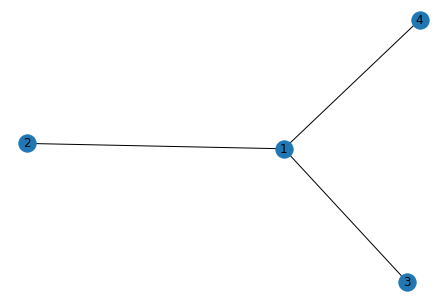

match_branches = [[1, 3]]
edges_to_delete (resolve crossover) = [[1, 2], [1, 4], [2, 3], [2, 4], [3, 4]]
edges_to_create (resolve crossover) = [[1, 3]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 5 because skeletal distance was 1892.7487816962093 and threshold was 2500
skip_nodes = [5]
edges_to_delete (cut_limb_network) = [[1, 2], [1, 4], [2, 3], [2, 4], [3, 4]]
edges_to_create = [[1, 3]]
Number of connected components = 3
Comp 0 = {1, 3}
Comp 1 = {0, 2, 5}
Comp 2 = {4}
curr_limb_copy.deleted_edges = [[1, 2], [1, 4], [2, 3], [2, 4], [3, 4]]
curr_limb_copy.created_edges = [[1, 3]]
After get best cut: cut_edges = [[1, 2], [1, 4], [2, 3], [2, 4], [3, 4]], added_edges = [[1, 3]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 3
Total number of graphs at the end of the split AFTER DIRECTIONAL = 3
No valid path so moving onto the next connection
Total number of graphs at the end of the spl

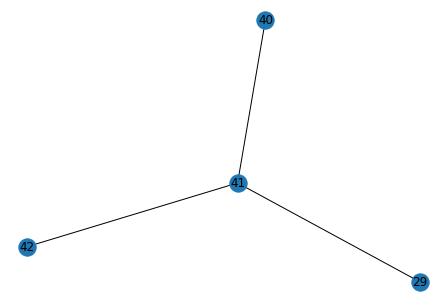

match_branches = [[40, 41]]
edges_to_delete (resolve crossover) = [[29, 40], [29, 41], [29, 42], [40, 42], [41, 42]]
edges_to_create (resolve crossover) = [[40, 41]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 47 because skeletal distance was 2357.748936553529 and threshold was 2500
skip_nodes = [47]
edges_to_delete (cut_limb_network) = [[29, 40], [29, 41], [29, 42], [40, 42], [41, 42]]
edges_to_create = [[40, 41]]
Number of connected components = 2
Comp 0 = {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69}
Comp 1 = {0, 21, 29}
curr_limb_copy.deleted_edges = [[29, 40], [29, 41], [29, 42], [40, 42], [41, 42]]
curr_limb_copy.created_edges = [[40, 41]]
After get best cut: cut_edges = [[29, 40], [29, 41], [29, 42], [40, 42], [41, 42]], added_edges = [[40, 41]]
total_soma_paths_to_

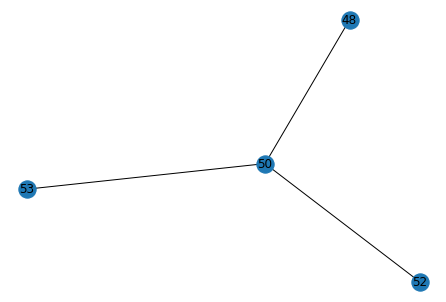

match_branches = [[48, 52]]
edges_to_delete (resolve crossover) = [[48, 50], [48, 53], [50, 52], [50, 53], [52, 53]]
edges_to_create (resolve crossover) = [[48, 52]]
curr_limb.deleted_edges 5 =[[29, 40], [29, 41], [29, 42], [40, 42], [41, 42]]
Skipping endnode 47 because skeletal distance was 2357.748936553529 and threshold was 2500
skip_nodes = [47]
edges_to_delete (cut_limb_network) = [[48, 50], [48, 53], [50, 52], [50, 53], [52, 53]]
edges_to_create = [[48, 52]]
Number of connected components = 5
Comp 0 = {64, 65, 66, 67, 68, 69, 42, 47, 48, 52, 56, 57, 58, 59, 60, 61, 62, 63}
Comp 1 = {0, 21, 29}
Comp 2 = {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 49, 50, 54, 55}
Comp 3 = {53}
Comp 4 = {51}
curr_limb_copy.deleted_edges = [[29, 40], [29, 41], [29, 42], [40, 42], [41, 42], [48, 50], [48, 53], [50, 52], [50, 53], [52, 53]]
curr_limb_copy.created_edges = [[40, 41], [

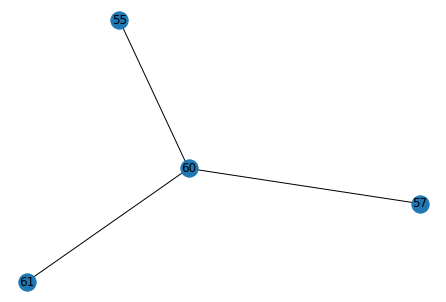

match_branches = [[55, 61], [57, 60]]
edges_to_delete (resolve crossover) = [[55, 57], [55, 60], [57, 61], [60, 61]]
edges_to_create (resolve crossover) = [[55, 61], [57, 60]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[55, 57], [55, 60], [57, 61], [60, 61]]
edges_to_create = [[55, 61], [57, 60]]
Number of connected components = 2
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75}
Comp 1 = {61, 55}
curr_limb_copy.deleted_edges = [[55, 57], [55, 60], [57, 61], [60, 61]]
curr_limb_copy.created_edges = [[55, 61], [57, 60]]
After get best cut: cut_edges = [[55, 57], [55, 60], [57, 61], [60, 61]], added_edges = [[55, 61], [57, 60]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 

  Edge: [16 17]: curr_angle = 38.62
  Edge: [17 19]: curr_angle = 35.33
  Edge: [19 20]: curr_angle = 8.44
  Edge: [20 24]: curr_angle = 19.4
  Edge: [24 35]: curr_angle = 37.15
  Edge: [35 74]: curr_angle = 64.19
  Edge: [74 56]: curr_angle = 61.66
  Edge: [56 60]: curr_angle = 37.78
  Edge: [60 57]: curr_angle = 21.94
  Edge: [57 58]: curr_angle = 18.72
  Edge: [58 68]: curr_angle = 19.17
  Edge: [68 67]: curr_angle = 19.83
  Edge: [67 64]: curr_angle = 20.54
  Edge: [64 65]: curr_angle = 18.72

Total time for doubling_back = 1.401231288909912

Attempting the width jump check (attempting from both sides)
  Edge: [16 17]: jump = -253.65
  Edge: [17 19]: jump = -201.68
  Edge: [19 20]: jump = 29.75
  Edge: [20 24]: jump = -2.59
  Edge: [24 35]: jump = -48.39
  Edge: [35 74]: jump = 150.09
  Edge: [74 56]: jump = 10.63
  Edge: [56 60]: jump = 95.24
  Edge: [60 57]: jump = -45.58
  Edge: [57 58]: jump = 138.16
  Edge: [58 68]: jump = 93.64
  Edge: [68 67]: jump = -37.85
  Edge: [67 64]: 

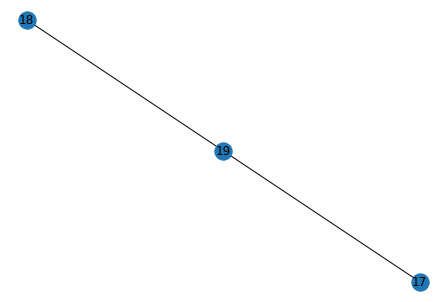

match_branches = [[17, 18]]
edges_to_delete (resolve crossover) = [[17, 19], [18, 19]]
edges_to_create (resolve crossover) = [[17, 18]]
edges_to_delete (cut_limb_network) = [array([17, 19]), array([18, 19])]
edges_to_create = [[17, 18]]
Number of connected components = 3
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 21, 22, 25, 26, 48, 49}
Comp 1 = {15, 19, 20, 23, 24, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75}
Comp 2 = {61, 55}
curr_limb_copy.deleted_edges = [[55, 57], [55, 60], [57, 61], [60, 61], array([17, 19]), array([18, 19])]
curr_limb_copy.created_edges = [[55, 61], [57, 60], [17, 18]]
After get best cut: cut_edges = [array([17, 19]), array([18, 19])], added_edges = [[17, 18]]
total_soma_paths_to_cut = [[55, 57], [55, 60], [57, 61], [60, 61]]
-----------counter = 1------------
 Cut iteration 2
Total number of graphs a

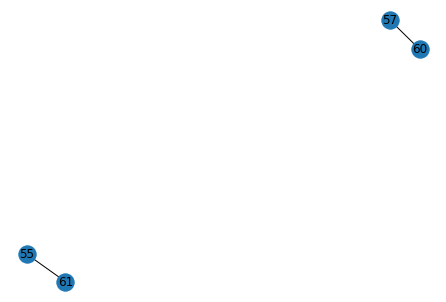

match_branches = [[55, 61], [57, 60]]
edges_to_delete (resolve crossover) = [[55, 57], [55, 60], [57, 61], [60, 61]]
edges_to_create (resolve crossover) = [[55, 61], [57, 60]]
curr_limb.deleted_edges 5 =[[55, 57], [55, 60], [57, 61], [60, 61], array([17, 19]), array([18, 19])]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[55, 57], [55, 60], [57, 61], [60, 61]]
edges_to_create = [[55, 61], [57, 60]]
Number of connected components = 3
Comp 0 = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 21, 22, 25, 26, 48, 49}
Comp 1 = {15, 19, 20, 23, 24, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 50, 51, 52, 53, 54, 56, 57, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75}
Comp 2 = {61, 55}
curr_limb_copy.deleted_edges = [[55, 57], [55, 60], [57, 61], [60, 61], array([17, 19]), array([18, 19]), [55, 57], [55, 60], [57, 61], [60, 61]]
curr_limb_copy.created_edges = [[55, 61], [57, 60], [17, 18], [55, 61], [57, 60]]
Af

  Edge: [65 64]: curr_angle = 18.72
  Edge: [64 67]: curr_angle = 20.54
  Edge: [67 68]: curr_angle = 19.83
  Edge: [68 58]: curr_angle = 19.17
  Edge: [58 57]: curr_angle = 18.72
  Edge: [57 60]: curr_angle = 21.94
  Edge: [60 59]: curr_angle = 28.58
  Edge: [59 63]: curr_angle = 9.36
  Edge: [63 66]: curr_angle = 37.28

Total time for doubling_back = 0.7594420909881592

Attempting the width jump check (attempting from both sides)
  Edge: [65 64]: jump = -119.94
  Edge: [64 67]: jump = -39.43
  Edge: [67 68]: jump = 37.85
  Edge: [68 58]: jump = -93.64
  Edge: [58 57]: jump = -138.16
  Edge: [57 60]: jump = 45.58
  Edge: [60 59]: jump = -102.28
  Edge: [59 63]: jump = -167.32
  Edge: [63 66]: jump = -23.16
Total time for width = 0.72340989112854
Path starting at 65 had err_edges: []
  Edge: [66 63]: jump = 23.16
  Edge: [63 59]: jump = 167.32
  Edge: [59 60]: jump = 102.28
  Edge: [60 57]: jump = -45.58
  Edge: [57 58]: jump = 138.16
  Edge: [58 68]: jump = 93.64
  Edge: [68 67]: jump

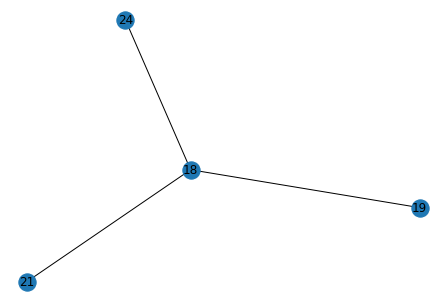

match_branches = [[19, 24]]
edges_to_delete (resolve crossover) = [[18, 19], [18, 21], [18, 24], [19, 21], [21, 24]]
edges_to_create (resolve crossover) = [[19, 24]]
curr_limb.deleted_edges 5 =[]
Skipping endnode 14 because skeletal distance was 1484.4569141412244 and threshold was 2500
skip_nodes = [14]
edges_to_delete (cut_limb_network) = [[18, 19], [18, 21], [18, 24], [19, 21], [21, 24]]
edges_to_create = [[19, 24]]
Number of connected components = 3
Comp 0 = {4, 12, 19, 24, 26, 27, 30, 37, 166, 167, 39, 42, 43, 53, 184, 64, 197, 70, 78, 209, 83, 212, 216, 217, 218, 91, 92, 222, 95, 96, 223, 226, 229, 230, 103, 105, 106, 107, 109, 110}
Comp 1 = {0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 22, 23, 25, 28, 29, 31, 32, 33, 34, 35, 36, 38, 40, 41, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 93, 94, 97, 98, 99, 100, 101, 102, 104, 108, 111, 112, 1

  Edge: [16 20]: curr_angle = 144.48

Total time for doubling_back = 0.10814261436462402
There were 1 edges that passed doubling back threshold of 100
Winning edge [16 20] had a doubling back of 144.4767541759947
***inside resolve crossover!!!!****
coordinate_branches = [16, 20, 25]
16 = red
20 = aqua
25 = purple
Angle between 16 and 20 = 72.08 
Angle between 16 and 25 = 35.0 
Angle between 20 and 25 = 72.96 
Final Matches = [[16, 25]]
matched_branches_revised = [[16, 25]]
Original graph


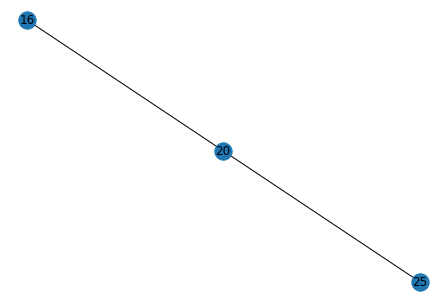

match_branches = [[16, 25]]
edges_to_delete (resolve crossover) = [[16, 20], [20, 25]]
edges_to_create (resolve crossover) = [[16, 25]]
edges_to_delete (cut_limb_network) = [array([16, 20]), array([20, 25])]
edges_to_create = [[16, 25]]
Number of connected components = 4
Comp 0 = {4, 12, 19, 24, 26, 27, 30, 37, 166, 167, 39, 42, 43, 53, 184, 64, 197, 70, 78, 209, 83, 212, 216, 217, 218, 91, 92, 222, 95, 96, 223, 226, 229, 230, 103, 105, 106, 107, 109, 110}
Comp 1 = {0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 22, 23, 25, 28, 29, 31, 32, 33, 34, 35, 36, 38, 40, 41, 44, 45, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 93, 94, 97, 98, 99, 100, 101, 102, 104, 108, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 1

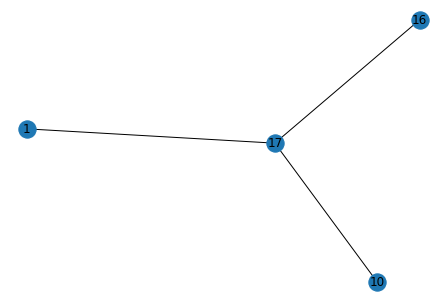

match_branches = [[1, 17], [10, 16]]
edges_to_delete (resolve crossover) = [[1, 10], [1, 16], [10, 17], [16, 17]]
edges_to_create (resolve crossover) = [[1, 17], [10, 16]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[1, 10], [1, 16], [10, 17], [16, 17]]
edges_to_create = [[1, 17], [10, 16]]
Number of connected components = 2
Comp 0 = {1, 3, 8, 11, 12, 13, 14, 15, 17, 23, 24, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39}
Comp 1 = {0, 2, 4, 5, 6, 7, 9, 10, 16, 18, 19, 20, 21, 22, 25, 26}
curr_limb_copy.deleted_edges = [[1, 10], [1, 16], [10, 17], [16, 17]]
curr_limb_copy.created_edges = [[1, 17], [10, 16]]
After get best cut: cut_edges = [[1, 10], [1, 16], [10, 17], [16, 17]], added_edges = [[1, 17], [10, 16]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so

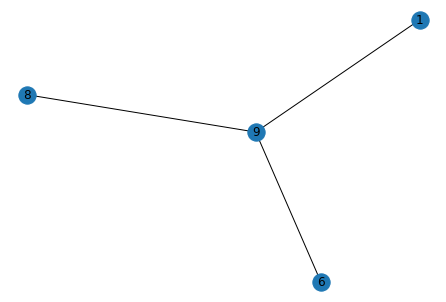

match_branches = [[1, 8], [6, 9]]
edges_to_delete (resolve crossover) = [[1, 6], [1, 9], [6, 8], [8, 9]]
edges_to_create (resolve crossover) = [[1, 8], [6, 9]]
curr_limb.deleted_edges 5 =[]
skip_nodes = []
edges_to_delete (cut_limb_network) = [[1, 6], [1, 9], [6, 8], [8, 9]]
edges_to_create = [[1, 8], [6, 9]]
Number of connected components = 2
Comp 0 = {0, 2, 3, 4, 5, 6, 9, 11}
Comp 1 = {8, 1, 10, 7}
curr_limb_copy.deleted_edges = [[1, 6], [1, 9], [6, 8], [8, 9]]
curr_limb_copy.created_edges = [[1, 8], [6, 9]]
After get best cut: cut_edges = [[1, 6], [1, 9], [6, 8], [8, 9]], added_edges = [[1, 8], [6, 9]]
total_soma_paths_to_cut = []
-----------counter = 0------------
 Cut iteration 1
Total number of graphs at the end of the split BEFORE DIRECTIONAL = 2
Total number of graphs at the end of the split AFTER DIRECTIONAL = 2
No valid path so moving onto the next connection
Total number of graphs at the end of the split = 2: [array([ 0,  2,  3,  4,  5,  6,  9, 11]), array([ 8,  1, 10,  7])]

In [11]:
start_time = time.time()
if not test_mode:
    time.sleep(random.randint(0, 800))
print('Populate Started')
if not test_mode:
    NeuronSplitSuggestions.populate(reserve_jobs=True, suppress_errors=True)
else:
    NeuronSplitSuggestions.populate(reserve_jobs=True, suppress_errors=True)
print('Populate Done')

print(f"Total time for NeuronSplitSuggestions populate = {time.time() - start_time}")